# Objective:

1. Determine land eligibility for photovoltaic (PV) modules in the <a href="https://en.wikipedia.org/wiki/Aachen_(district)">Aachen administration region</a> considering that...
    1. PV modules should not cover agricultural areas (because people need to eat)
    2. PV modules should not be within 200 meters of a major road way (because they may get dirty)
    3. PV modules should not be within 1000 meters of a settlement area (because they are too shiny)

2. Save the resulting available lands to a raster (.tif) file


## Given that:

1. **aachenRegion** is a path to a vector file describing the study region
2. **clcRaster** is a path to a local copy of the <a href="http://land.copernicus.eu/pan-european/corine-land-cover/clc-2012/view">Corine Land Cover</a> dataset
3. **roadways** is a path to a vector file which describes the path of all roadways in the study area
    - Each feature in the roadways vector also has attribute named 'type' distinguishing the class of the that specific route (for example: motorway, primary, secondary, residential, service, ect...)

In [1]:
# Import GLAES
import glaes as gl

from os.path import join
%matplotlib inline

# 1. An *ExclusionCalculator* object is initialized

The Aachen region will be the study area

The [EPSG:3035](http://spatialreference.org/ref/epsg/etrs89-etrs-laea/) spatial reference system is used, since it describes relational distances in meters over the entire study area

An inherent resolution of 100 x 100 meters is chosen as this is small enough to capture small details, but not so large as to require too many resources


In [2]:
# Choose a region to operate on (Here, a predefined region for Aachen, Germany is used)
regionPath = gl._test_data_['aachenShapefile.shp']

# Initialize ExclusionCalculator object
ec = gl.ExclusionCalculator(regionPath, srs=3035, pixelSize=100)

# Visualize availability 

The current availability is visualized using the 'draw' command:

* Since the ExclusionCalculator was just initialized, all areas are currently available (shown as blue)

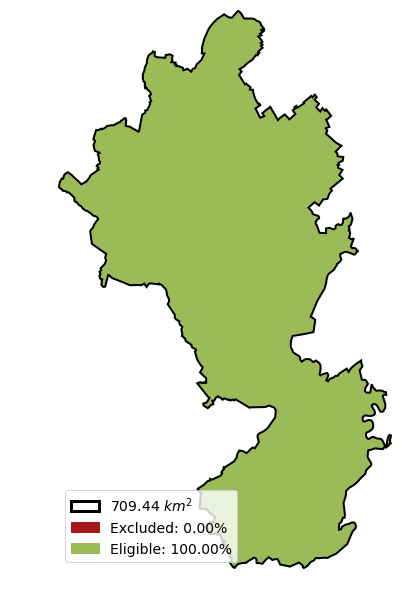

In [3]:
# Visualize avilability
ec.draw()

# 2. Exclusion A

All agricultural areas are excluded

* Integer values 12-22 found in the CLC dataset indicate that the associated pixel is primarily used for agricultural purposes
* Excluded areas are shown in red

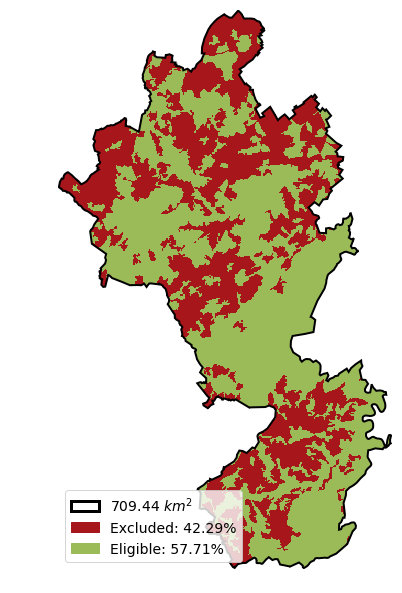

In [4]:
# Set a path to a local copy of the CLC raster dataset (Here, a small sample is provided around Aachen)
clcRasterPath = gl._test_data_["clc-aachen_clipped.tif"]

# Apply exclusion
ec.excludeRasterType(clcRasterPath, value=(12,22))

# Visualize
ec.draw()

# 3. Exclusion B

1 km around settlement areas are now excluded on top of the agricultural exclusions

* Integer values 1 and 2 found in the CLC dataset indicate that the associated pixel is primarily composed of "urban fabric"

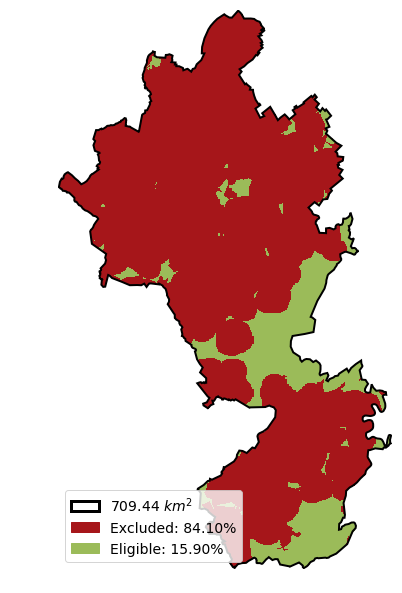

In [5]:
# Apply exclusion
ec.excludeRasterType(clcRasterPath, value=(1,2), buffer=1000)

# Visualize
ec.draw()

# 3. Exclusion C

200 meters from all major roadways are finally excluded on top of the previous exclusions

* Only major road ways are desired, not the smaller and less common roads
* This is interpreted as roadways which are designated as 'motorway', 'primary', or 'trunk'
    - An <a href="http://www.gdal.org/ogr_sql.html">SQL-like</a> where-statement is used to select only these features

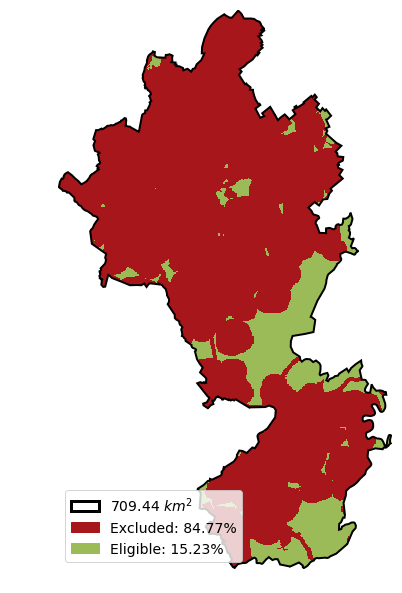

In [6]:
# Set a path to a local copy of the OSM roads dataset (Here, a small sample is provided around Aachen)
roadwaysPath = gl._test_data_["aachenRoads.shp"]

# Apply Exclusion
whereStatement = "type='motorway' OR type='primary' OR type='trunk'"
ec.excludeVectorType(roadwaysPath, where=whereStatement, buffer=200)

# Visualize
ec.draw()

# 4. Save result to file

In [7]:
ec.save("aachens_best_pv_spots.tif", overwrite=True)

---
# Alternative meathod: Using Prior datasets

Since Aachen is in Europe, an *almost* equivalent analysis to the one above could be evaluated using the Prior datasets.
This has the advantage that the evaluator (you!) does not need to have a copy of the various datasets used (except, of course, the Prior datasets)

---
**NOTE**

Be sure the Prior datasets have been properly installed, or that the setPriorDirectory functioned has been called

---

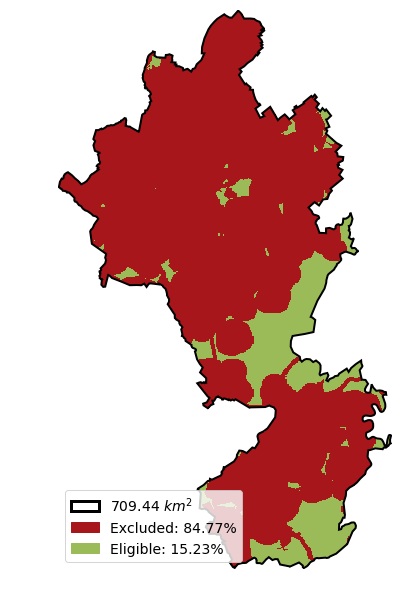

In [8]:
ec_p = gl.ExclusionCalculator(regionPath, srs=3035, pixelSize=100)

ec_p.excludePrior("agriculture_proximity", value=(None,0))
ec_p.excludePrior("settlement_proximity", value=(None,1000))
ec_p.excludePrior("roads_main_proximity", value=(None,200))
                  
ec_p.draw()